<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Ressentis_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification de ressentis avec distilBERT**

L'objectif est de créer un modèle qui prend en entrée des commentaires (en Anglais) et attribue à chacun un ressenti positif ou négatif.  
Le modèle est composé de deux parties :  
* DistilBERT va encoder le commentaire et en extraire des informations qui seront passées ensuite au réseau de neurones.  
* Le modèle suivant est un réseau de neurones qui sera créé avec Keras.  

<img src="https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Images/StructureBERT.png" />  
  
  Les données qui s'échangent entre les deux modèles sont des vecteurs de dimension 768. Ces vecteurs sont l'équivalent de l'application d'un algorithme de prolongation lexicale sur les mots qui composent le commentaire.

# **Installation et importation des librairies**


In [2]:
!pip install transformers --quiet

     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 1.1MB 25.7MB/s 
     |████████████████████████████████| 890kB 47.3MB/s 
     |████████████████████████████████| 3.0MB 52.3MB/s 


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import DistilBertConfig
from transformers import TFDistilBertModel
from transformers import AutoTokenizer

import matplotlib.pyplot as plt

import random

# **Importation des données**

On utilise la librairie pandas pour lire les données depuis le fichier csv disponible sur le site de [standford](https://nlp.stanford.edu/sentiment/index.html) qui contient des commentaires sur des films, chacun d'eux avec une note positive (1) ou négative (0).

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/AlexandreBourrieau/ML-F1/master/Carnets%20Jupyter/Donn%C3%A9es/train.csv', delimiter='\t', header=None)

Affiche quelques informations :

In [7]:
print(df[0:10])
print("Total des données : ", str(len(df)))
print("Nombre d'avis positifs et négatifs : ",df[1].value_counts())

                                                   0  1
0  a stirring , funny and finally transporting re...  1
1  apparently reassembled from the cutting room f...  0
2  they presume their audience wo n't sit still f...  0
3  this is a visually stunning rumination on love...  1
4  jonathan parker 's bartleby should have been t...  1
5  campanella gets the tone just right funny in t...  1
6  a fan film that for the uninitiated plays bett...  0
7  b art and berling are both superb , while hupp...  1
8  a little less extreme than in the past , with ...  0
9                       the film is strictly routine  0
Total des données :  6920
Nombre d'avis positifs et négatifs :  1    3610
0    3310
Name: 1, dtype: int64


# **Préparation des données**

# Séparation des données d'entrainement et de test 
On commence par récupérer 75% des données pour l'entrainement, et le reste pour les tests :

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/SeparationData.png?raw=true"/>

In [8]:
# Chargement des commentaires et des ressentis
commentaires = df[0].astype(str).tolist()    # Récupère tous les commentaires dans une liste python
ressentis = df[1].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)               # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires, labels, test_size=0.25)

# Tokénisation  
La première étape est de tokéniser les commentaires : les mots sont décomposés en index numériques au format BERT.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/TokenizeBERT.png?raw=true"/>

Après tokénisation, on obtient une liste de séquences et chaque séquence représente une liste d'index. On souhaite que BERT analyse toutes les séquences en une seule fois (ce qui est plus rapide). Il faut donc que toutes les séquences aient la même taille. On va donc ajouter du bourrage pour égaliser la longueur des séquences. Cela est indiqué avec le paramètre `padding='True'`.  
Lorsque un bourrage est ajouté, il faut que BERT ne prenne pas en compte les mots à cette position (car il n'y en a pas !). Cette restriction est réalisé grace à l'`attention_mask`

In [9]:
LONGUEUR_MAX_COMMENTAIRE = 100

# Instanciation du tokeniseur
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

# Préparation des données d'entrainement
output_tokenizer_entrainement = tokenizer(x_entrainement,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=True, return_tensors='tf',add_special_tokens=True)

# Préparation des données de tests
output_tokenizer_tests = tokenizer(x_test,max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=True, return_tensors='tf',add_special_tokens=True)

Regardons un peu comment sont formatées les données en sortie du tokéniseur :

In [7]:
output_tokenizer_entrainement

{'input_ids': <tf.Tensor: shape=(5190, 100), dtype=int32, numpy=
array([[  101,  1999, 20740, ...,     0,     0,     0],
       [  101,  1037, 13940, ...,     0,     0,     0],
       [  101,  1996,  3861, ...,     0,     0,     0],
       ...,
       [  101,  3811, 17837, ...,     0,     0,     0],
       [  101,  1999,  2026, ...,     0,     0,     0],
       [  101,  8040,  5369, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(5190, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

Regardons comment le premier commentaire a été encodé :

In [8]:
print("Commentaire original :", x_entrainement[0])
print("input_ids: ", output_tokenizer_entrainement['input_ids'][0])
print("attention_mask: ", output_tokenizer_entrainement['attention_mask'][0])

Commentaire original : infidelity drama is nicely shot , well edited and features a standout performance by diane lane
input_ids:  tf.Tensor(
[  101  1999 20740 18605  3689  2003 19957  2915  1010  2092  5493  1998
  2838  1037  3233  5833  2836  2011 12082  4644   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)
attention_mask:  tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Regardons les 5 premiers résultats de la tokénisation : On peut identifier les mot-clés **[CLS]** (valeur : 101) et **[SEP]** (valeur : 102)

In [128]:
for i in range (0,5):
  print(output_tokenizer_entrainement['input_ids'][i])

tf.Tensor(
[  101  2062  1997  1996  2168  2214 13044  5365  2038  2042  2667  2000
  3413  2125  2004 11701  9458  4024  2005  2070  2051  2085   102     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)
tf.Tensor(
[ 101 4299 2100 9378 2100  102    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

# **Définition et utilisation du modèle distilBERT avec Keras**

Les données d'entrées étant maintenant correctement préparées, commençons par définir le modèle distilBERT pour ensuite l'appliquer aux données afin de réaliser l'opération de prolongation lexicale.  

<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/DistilBERT_process.png?raw=true"/>  
La fonction `model()` permet d'exécuter le modèle sur les séquences d'entrées.

In [25]:
# Configuration du modèle distilBERT
config = DistilBertConfig(num_labels=1)           # 1 label
config.output_hidden_states = False               # Ne récupère pas la totalité des couches mais uniquement la dernière

# Instanciation du modèle distilBERT
transformer_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased', config = config)

# Défintion du format des entrées du modèle
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32') 

# Création de la sortie du modèle
sortie_distilBERT = transformer_model(entrees_ids, attention_mask=entrees_masks)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Pour chaque commentaire en entrée, la sortie du modèle distilBERT est un vecteur de dimension MAX_SEQUENCE_LENGTHx768 :
* Il y a au maximum MAX_SEQUENCE_LENGTH mots dans chaque commentaire
* Il y a un vecteur en sortie du modèle par mot dans chaque commentaire
* Le vecteur qui code chaque mot est de dimension 768

Vérifions cela en regardant le format de la sortie du modèle :

In [10]:
sortie_distilBERT

(<tf.Tensor 'tf_distil_bert_model/distilbert/transformer/layer_._5/output_layer_norm/batchnorm/add_1:0' shape=(None, 100, 768) dtype=float32>,)

Parmi les MAX_SEQUENCE_LENGTH vecteurs en sortie, il ne nous faut que le premier (celui qui correspond au mot clé [CLS]). On doit donc récupérer, pour chaque commentaire, le premier vecteur de dimension 768 parmi les MAX_SEQUENCE_LENGTH en sortie :  
  
  
<img src="https://github.com/AlexandreBourrieau/ML-F1/blob/master/Carnets%20Jupyter/Images/Slice_SortieBERT.png?raw=true"/>  

In [26]:
sortie_CLS = sortie_distilBERT[0][:,0,:]

In [43]:
model_distilBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_CLS,trainable=False)
model_distilBERT.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_4 (TFDisti ((None, 100, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model_

Exécutons maintenant distilBERT sur les 10 premiers commentaires afin de regarder le format des sorties obtenues :

In [34]:
sortie_prolongation_lexicale = model_distilBERT.predict([output_tokenizer_entrainement['input_ids'][1:10],output_tokenizer_entrainement['attention_mask'][1:10]],verbose=1)
print("Commentaire :", commentaires[0])
print("input_ids", output_tokenizer_entrainement['input_ids'][0])
print("Sortie BERT", sortie_prolongation_lexicale[0])

1/1 [==============================] - 0s 3ms/step
Commentaire : a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
input_ids tf.Tensor(
[  101  2320  2002  4627  4083  2000 12014  2007  4507  2438  2000  2468
 20172 22856  1998  7965  1010  1996  2143  4150 16014  8231  7511   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int32)
Sortie BERT [-1.11723870e-01  1.66897267e-01 -9.15018544e-02 -1.33393317e-01
 -8.53074193e-02 -3.91883180e-02  6.67528659e-02  4.16917652e-01
 -1.15582824e-01 -1.89734966e-

# **Ajout du réseau de neurones en sortie du modèle distilBERT**

In [54]:
output = Dense(2, activation='softmax')(sortie_CLS)
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.layers[2].trainable = False
model.summary()

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_4 (TFDisti ((None, 100, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model_

In [56]:
MAX_SIZE = 2000
history = model.fit([output_tokenizer_entrainement['input_ids'][1:MAX_SIZE],output_tokenizer_entrainement['attention_mask'][1:MAX_SIZE]], y_entrainement[1:MAX_SIZE], epochs=5, verbose=1, batch_size = 3, validation_data=([output_tokenizer_tests['input_ids'][1:MAX_SIZE],output_tokenizer_tests['attention_mask'][1:MAX_SIZE]],y_test[1:MAX_SIZE]))

Epoch 1/5
667/667 [==============================] - 23s 35ms/step - loss: 0.4300 - accuracy: 0.8049 - val_loss: 0.3852 - val_accuracy: 0.8363
Epoch 2/5
667/667 [==============================] - 23s 35ms/step - loss: 0.4035 - accuracy: 0.8124 - val_loss: 0.4140 - val_accuracy: 0.8115
Epoch 3/5
667/667 [==============================] - 23s 35ms/step - loss: 0.3869 - accuracy: 0.8339 - val_loss: 0.3638 - val_accuracy: 0.8421
Epoch 4/5
667/667 [==============================] - 23s 35ms/step - loss: 0.3771 - accuracy: 0.8314 - val_loss: 0.3580 - val_accuracy: 0.8473
Epoch 5/5
667/667 [==============================] - 23s 35ms/step - loss: 0.3614 - accuracy: 0.8434 - val_loss: 0.3470 - val_accuracy: 0.8531


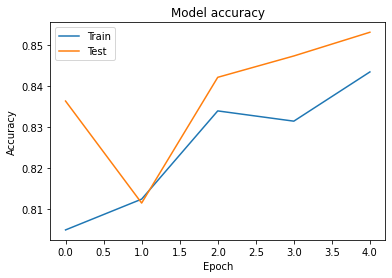

In [57]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# **Fine Tuning**

In [62]:
model.layers[2].trainable = True
output = Dense(2, activation='softmax')(sortie_CLS)
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
model.summary()

Model: "functional_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_token (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
masked_token (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_4 (TFDisti ((None, 100, 768),)  66362880    input_token[0][0]                
                                                                 masked_token[0][0]               
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 768)]        0           tf_distil_bert_model_

In [ ]:
MAX_SIZE = 2000
history2 = model.fit([output_tokenizer_entrainement['input_ids'][1:MAX_SIZE],output_tokenizer_entrainement['attention_mask'][1:MAX_SIZE]], y_entrainement[1:MAX_SIZE], epochs=5, verbose=1, batch_size = 3, validation_data=([output_tokenizer_tests['input_ids'][1:MAX_SIZE],output_tokenizer_tests['attention_mask'][1:MAX_SIZE]],y_test[1:MAX_SIZE]))

Epoch 1/5
666/667 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8764

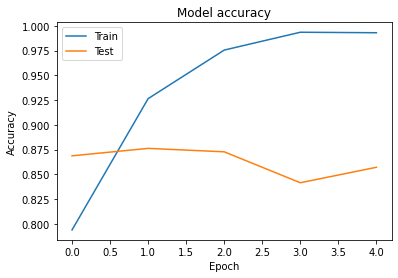

In [61]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()